<a href="https://colab.research.google.com/github/Keshav-Sundar-4/Gray-Scott/blob/main/Gray_Scott_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/Keshav-Sundar-4/Gray-Scott/main/Gray_Scott_Target3.png

--2024-11-04 00:37:20--  https://raw.githubusercontent.com/Keshav-Sundar-4/Gray-Scott/main/Gray_Scott_Target3.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531969 (520K) [image/png]
Saving to: ‘Gray_Scott_Target3.png’

Gray_Scott_Target3. 100%[===================>] 519.50K  --.-KB/s    in 0.03s   

2024-11-04 00:37:20 (16.4 MB/s) - ‘Gray_Scott_Target3.png’ saved [531969/531969]



In [ ]:
#@title Imports

%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pl
from IPython.display import clear_output, display
from PIL import Image
from scipy.signal import convolve2d
import time
import os


In [ ]:
#@title Seed State + helper functions

def seed_state(N, random_influence=0.2):
    """
    Initialize concentration grids U and V.

    Parameters:
    - N: Grid size (N x N)
    - random_influence: Amount of noise to add

    Returns:
    - U, V: Initialized concentration grids
    """
    U = (1 - random_influence) * np.ones((N, N), dtype=np.float32) + \
        random_influence * np.random.random((N, N)).astype(np.float32)
    V = random_influence * np.random.random((N, N)).astype(np.float32)

    # Add disturbance in the center
    N2 = N // 2
    r = int(N / 10.0)

    U[N2-r:N2+r, N2-r:N2+r] = 0.50
    V[N2-r:N2+r, N2-r:N2+r] = 0.25

    return U, V

def to_rgb(U, V):
    """
    Convert U and V concentration grids to an RGB image.

    Parameters:
    - U, V: Concentration grids

    Returns:
    - image: PIL Image in RGB format
    """
    U_np = U.numpy().squeeze()
    V_np = V.numpy().squeeze()

    # Normalize U and V to [0, 1]
    U_normalized = np.clip(U_np, 0, 1)
    V_normalized = np.clip(V_np, 0, 1)

    # Create RGB channels
    red_channel = (U_normalized * 255).astype(np.uint8)
    green_channel = (V_normalized * 255).astype(np.uint8)
    blue_channel = np.zeros_like(red_channel)

    # Stack channels to create RGB image
    rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)
    image = Image.fromarray(rgb_image, mode='RGB')
    return image

def load_target_image(file_path, size=256):
    """
    Load and preprocess the target image.

    Parameters:
    - file_path: Path to the target image file
    - size: Desired size to resize the image (size x size)

    Returns:
    - target_U, target_V: Target concentration grids
    """
    image = Image.open(file_path).convert('RGB')
    image = image.resize((size, size))
    image_np = np.array(image).astype(np.float32) / 255.0

    # Extract U and V from RGB channels
    target_U = image_np[..., 0]  # Red channel
    target_V = image_np[..., 1]  # Green channel

    # Expand dimensions to match simulation variables
    target_U = tf.expand_dims(tf.expand_dims(target_U, axis=0), axis=-1)  # Shape: [1, size, size, 1]
    target_V = tf.expand_dims(tf.expand_dims(target_V, axis=0), axis=-1)  # Shape: [1, size, size, 1]

    return target_U, target_V


In [ ]:
#@title Paramter Creation

# Parameters
Du = 0.16       # Diffusion coefficient for U
Dv = 0.08       # Diffusion coefficient for V
F = 0.060       # Feed rate
k = 0.062       # Kill rate
dt = 1.0        # Time step size
size = 256      # Grid size (size x size)

# Laplacian kernel for convolution
laplacian_kernel = tf.constant([[0, 1, 0],
                                [1, -4, 1],
                                [0, 1, 0]], dtype=tf.float32)
laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])  # Shape: [filter_height, filter_width, in_channels, out_channels]

# Initialize U and V
U_init, V_init = seed_state(size)

# Convert to TensorFlow variables and add batch and channel dimensions
U = tf.Variable(tf.expand_dims(tf.expand_dims(U_init, axis=0), axis=-1))  # Shape: [1, size, size, 1]
V = tf.Variable(tf.expand_dims(tf.expand_dims(V_init, axis=0), axis=-1))  # Shape: [1, size, size, 1]




In [ ]:
#@title Update Function

@tf.function
def gray_scott_update(U, V, Du, Dv, F, k, dt=1.0):
    """
    Perform one update step of the Gray-Scott model.

    Parameters:
    - U, V: Current concentration grids
    - Du, Dv: Diffusion coefficients
    - F, k: Feed and kill rates
    - dt: Time step size
    """
    # Compute Laplacian using convolution
    laplacian_U = tf.nn.conv2d(U, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')
    laplacian_V = tf.nn.conv2d(V, laplacian_kernel, strides=[1, 1, 1, 1], padding='SAME')

    # Reaction terms
    UVV = U * V * V

    # Update equations
    dU = Du * laplacian_U - UVV + F * (1 - U)
    dV = Dv * laplacian_V + UVV - (F + k) * V

    # Update concentrations
    U.assign_add(dU * dt)
    V.assign_add(dV * dt)

    # Clip values to maintain stability
    U.assign(tf.clip_by_value(U, 0.0, 1.0))
    V.assign(tf.clip_by_value(V, 0.0, 1.0))

In [ ]:
#@title tf simulation

# Number of simulation steps
num_steps = 20000

# Visualization interval (steps between frames)
vis_interval = 500

# Initialize matplotlib figure
plt.figure(figsize=(4,4))

for step in range(1, num_steps + 1):
    gray_scott_update(U, V, Du, Dv, F, k, dt)

    if step % vis_interval == 0:
        # Visualize the current state
        image = to_rgb(U, V)
        plt.imshow(image)
        plt.title(f"Step {step}")
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(0.1)  # Pause to allow the image to render

In [ ]:
U, V = (load_target_image('Gray_Scott_Target3.png'))
image = to_rgb(U, V)
display(image)

In [ ]:
#@title Gray Scott Model

class GrayScottModel():
    def __init__(self, Du, Dv, F, k, dt=1.0, size=256):
        self.Du = tf.Variable(Du, dtype=tf.float32, trainable=True, name='Du')
        self.Dv = tf.Variable(Dv, dtype=tf.float32, trainable=True, name='Dv')
        self.F = tf.Variable(F, dtype=tf.float32, trainable=True, name='F')
        self.k = tf.Variable(k, dtype=tf.float32, trainable=True, name='k')
        self.dt = dt
        self.size = size
        U_init, V_init = self.seed_state(size)
        self.U = tf.Variable(tf.expand_dims(tf.expand_dims(U_init, axis=0), axis=-1), dtype=tf.float32)
        self.V = tf.Variable(tf.expand_dims(tf.expand_dims(V_init, axis=0), axis=-1), dtype=tf.float32)
        laplacian_kernel = tf.constant([[0, 1, 0],
                                        [1, -4, 1],
                                        [0, 1, 0]], dtype=tf.float32)
        self.laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])

    def seed_state(self, size):
        U = np.ones((size, size), dtype=np.float32)
        V = np.zeros((size, size), dtype=np.float32)
        r = 20
        U[size//2 - r:size//2 + r, size//2 - r:size//2 + r] = 0.50
        V[size//2 - r:size//2 + r, size//2 - r:size//2 + r] = 0.25
        U += 0.05 * np.random.rand(size, size).astype(np.float32)
        V += 0.05 * np.random.rand(size, size).astype(np.float32)
        return U, V

    def step(self):
        laplace_U = tf.nn.conv2d(self.U, self.laplacian_kernel, strides=1, padding='SAME')
        laplace_V = tf.nn.conv2d(self.V, self.laplacian_kernel, strides=1, padding='SAME')
        UVV = self.U * self.V * self.V
        dU = self.Du * laplace_U - UVV + self.F * (1 - self.U)
        dV = self.Dv * laplace_V + UVV - (self.F + self.k) * self.V
        self.U.assign_add(dU * self.dt)
        self.V.assign_add(dV * self.dt)

    def run(self, steps=1000):
        for _ in tf.range(steps):
            self.step()
        return self.V

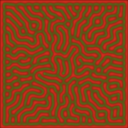

In [ ]:
#@title Training
target_image = Image.open('Gray_Scott_Target3.png').convert('RGB')
target_image = target_image.resize((128,128), Image.LANCZOS) #reshape to 100
display(target_image)


In [ ]:
#@title Training Setup
# Initialize the StyleModel
style_model = StyleModel()
model = GrayScottModel(Du = 0.16, Dv = 0.08, F = 0.060, k = 0.062, dt = 1.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)


# Define the Gray-Scott Model with Batch Support
class GrayScottModel:
    def __init__(self, Du, Dv, F, k, dt=1.0, size=256):
        # Initialize parameters as trainable variables
        self.Du = tf.Variable(Du, dtype=tf.float32, trainable=True, name='Du')
        self.Dv = tf.Variable(Dv, dtype=tf.float32, trainable=True, name='Dv')
        self.F = tf.Variable(F, dtype=tf.float32, trainable=True, name='F')
        self.k = tf.Variable(k, dtype=tf.float32, trainable=True, name='k')
        self.dt = dt
        self.size = size

        # Laplacian kernel for convolution
        laplacian_kernel = tf.constant([[0, 1, 0],
                                        [1, -4, 1],
                                        [0, 1, 0]], dtype=tf.float32)
        self.laplacian_kernel = tf.reshape(laplacian_kernel, [3, 3, 1, 1])  # Shape: [filter_height, filter_width, in_channels, out_channels]

    def seed_state(self, batch_size):
        """
        Generates seed states for the Gray-Scott simulation.

        Args:
            batch_size (int): Number of seed states to generate.

        Returns:
            U (tf.Tensor): Tensor of shape [batch_size, size, size, 1].
            V (tf.Tensor): Tensor of shape [batch_size, size, size, 1].
        """
        U = np.ones((batch_size, self.size, self.size), dtype=np.float32)
        V = np.zeros((batch_size, self.size, self.size), dtype=np.float32)

        r = 20  # Radius of the perturbation
        for i in range(batch_size):
            U[i, self.size//2 - r:self.size//2 + r, self.size//2 - r:self.size//2 + r] = 0.50
            V[i, self.size//2 - r:self.size//2 + r, self.size//2 - r:self.size//2 + r] = 0.25
            U[i] += 0.05 * np.random.rand(self.size, self.size).astype(np.float32)
            V[i] += 0.05 * np.random.rand(self.size, self.size).astype(np.float32)

        # Convert to TensorFlow tensors and add channel dimension
        U = tf.convert_to_tensor(U[..., np.newaxis], dtype=tf.float32)  # Shape: [batch_size, size, size, 1]
        V = tf.convert_to_tensor(V[..., np.newaxis], dtype=tf.float32)  # Shape: [batch_size, size, size, 1]
        return U, V

    def step(self, U, V):
        """
        Performs a single simulation step.

        Args:
            U (tf.Tensor): Current U state, shape [batch_size, size, size, 1].
            V (tf.Tensor): Current V state, shape [batch_size, size, size, 1].

        Returns:
            U_new (tf.Tensor): Updated U state.
            V_new (tf.Tensor): Updated V state.
        """
        # Compute Laplacian
        laplace_U = tf.nn.conv2d(U, self.laplacian_kernel, strides=1, padding='SAME')
        laplace_V = tf.nn.conv2d(V, self.laplacian_kernel, strides=1, padding='SAME')

        # Reaction terms
        UVV = U * V * V
        dU = self.Du * laplace_U - UVV + self.F * (1 - U)
        dV = self.Dv * laplace_V + UVV - (self.F + self.k) * V

        # Update rules
        U_new = U + dU * self.dt
        V_new = V + dV * self.dt

        return U_new, V_new

    def run(self, U_init, V_init, steps=1000):
        """
        Runs the simulation for a specified number of steps.

        Args:
            U_init (tf.Tensor): Initial U states, shape [batch_size, size, size, 1].
            V_init (tf.Tensor): Initial V states, shape [batch_size, size, size, 1].
            steps (int): Number of simulation steps.

        Returns:
            V (tf.Tensor): Final V states after simulation, shape [batch_size, size, size, 1].
        """
        U, V = U_init, V_init
        for _ in tf.range(steps):
            U, V = self.step(U, V)
        return V


# Initialize the Gray-Scott model
model = GrayScottModel(Du=0.16, Dv=0.08, F=0.060, k=0.062, dt=1.0, size=256)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Initialize a pool of seed states
pool_size = 100  # Adjust based on memory and requirements
initial_U, initial_V = model.seed_state(pool_size)
pool = initial_V.numpy()  # Shape: [pool_size, size, size, 1]

# Initialize loss log
loss_log = []

# Define model name for saving checkpoints
model_name = 'gray_scott_model'

# Define helper functions
def to_rgb(images):
    """
    Converts single-channel images to RGB by replicating the channel.

    Args:
        images (tf.Tensor): Tensor of shape [batch_size, size, size, 1].

    Returns:
        tf.Tensor: Tensor of shape [batch_size, size, size, 3].
    """
    return tf.tile(images, [1, 1, 1, 3])

def imshow(image, title=None):
    """
    Displays an image using matplotlib.

    Args:
        image (tf.Tensor or np.ndarray): Image tensor.
        title (str, optional): Title of the image.
    """
    pl.figure(figsize=(6, 6))
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    if len(image.shape) == 4:
        image = image[0]  # Remove batch dimension
    if image.shape[-1] == 1:
        image = image[..., 0]
        pl.imshow(image, cmap='gray')
    else:
        pl.imshow(image.astype(np.uint8))
    if title:
        pl.title(title)
    pl.axis('off')
    pl.show()

def seed_f(batch_size, size=256):
    """
    Generates seed states for injecting into the pool.

    Args:
        batch_size (int): Number of seed states to generate.
        size (int): Size of the grid.

    Returns:
        tf.Tensor: Seed V states, shape [batch_size, size, size, 1].
    """
    _, V = model.seed_state(batch_size)
    return V.numpy()



In [ ]:
#@title Train Step
@tf.function
def train_step(batch_V, target_image):
    """
    Performs a single training step to update the Gray-Scott model parameters
    based on the style loss between the generated images and the target image.

    Args:
        batch_V (tf.Tensor): Tensor of shape [batch_size, size, size, 1], initial V states.
        target_image (tf.Tensor): Tensor of shape [1, size, size, 3], target image for style matching.

    Returns:
        loss (tf.Tensor): The computed style loss for this training step.
        generated_V (tf.Tensor): The generated V channel images after simulation.
    """
    with tf.GradientTape() as tape:
        # Convert batch_V to TensorFlow tensor
        batch_V_tf = tf.convert_to_tensor(batch_V, dtype=tf.float32)  # Shape: [batch_size, size, size, 1]

        # Initialize U to 1 for all simulations
        batch_size = tf.shape(batch_V_tf)[0]
        U_init = tf.ones_like(batch_V_tf)  # Shape: [batch_size, size, size, 1]

        # Run the Gray-Scott simulation
        generated_V = model.run(U_init, batch_V_tf, steps=1000)  # Shape: [batch_size, size, size, 1]

        # Prepare the generated images for the StyleModel
        # Scale to [0, 255]
        generated_image = tf.clip_by_value(generated_V, 0.0, 1.0) * 255.0  # Shape: [batch_size, size, size, 1]
        generated_image_rgb = to_rgb(generated_image)  # Shape: [batch_size, size, size, 3]

        # Ensure target_image has the same batch size by tiling
        target_image_batch = tf.tile(target_image, [batch_size, 1, 1, 1])  # Shape: [batch_size, size, size, 3]

        # Compute style features for generated and target images
        style_generated, _ = style_model.calc_style_content(generated_image_rgb)
        style_target, _ = style_model.calc_style_content(target_image_batch)

        # Compute the style loss
        loss = style_loss(style_generated, style_target)

    # Compute gradients with respect to the model parameters
    gradients = tape.gradient(loss, [model.Du, model.Dv, model.F, model.k])

    # Apply gradients to update the parameters
    optimizer.apply_gradients(zip(gradients, [model.Du, model.Dv, model.F, model.k]))

    # Enforce parameter constraints to keep them within valid ranges
    model.Du.assign(tf.clip_by_value(model.Du, 1e-4, 1.0))
    model.Dv.assign(tf.clip_by_value(model.Dv, 1e-4, 1.0))
    model.F.assign(tf.clip_by_value(model.F, 0.0, 1.0))
    model.k.assign(tf.clip_by_value(model.k, 0.0, 1.0))

    return loss, generated_V


In [ ]:
#@title Training Loop

# Load and preprocess the target image
target_image = Image.open('Gray_Scott_Target3.png').convert('RGB')  # Replace with your image path
target_image = target_image.resize((128, 128), Image.LANCZOS)       # Resize to match simulation grid size
target_image = np.array(target_image)                               # Convert PIL Image to NumPy array
target_image = tf.convert_to_tensor(target_image, dtype=tf.float32) # Convert to TensorFlow tensor
target_image_tensor = tf.expand_dims(target_image, axis=0)                # Add batch dimension: [1, 128, 128, 3]

# Training Loop Parameters
num_iterations = 20000
batch_size = 4

# Initialize loss log as an empty list to ensure it always holds a numeric type
loss_log = []

for i in range(num_iterations):
    # Sample a random batch from the pool
    batch_indices = np.random.choice(pool_size, batch_size, replace=False)
    batch_V = pool[batch_indices]  # Shape: [batch_size, size, size, 1]

    # Periodically inject seed states into the batch
    if i % 32 == 0:
        # Generate new seed states
        new_V = seed_f(1, size=model.size)  # Shape: [1, size, size, 1]
        # Replace the first image in the batch with a new seed state
        batch_V[0] = new_V[0]

    # Perform a training step by passing the NumPy array batch_V and the Tensor target_image_tensor
    loss, generated_V = train_step(batch_V, target_image_tensor)

    # Update the pool with the newly generated images (convert Tensor to NumPy)
    pool[batch_indices] = generated_V.numpy()

    # Log the loss (convert to float by averaging over the batch and then to Python float)
    loss_scalar = float(loss.numpy().mean())
    loss_log.append(loss_scalar) # Append the loss scalar to the list

    # Periodically plot loss and show images
    if i % 16 == 0:
        clear_output(wait=True)
        pl.figure(figsize=(18, 6))

        # Plot the loss log
        pl.subplot(1, 3, 1)
        pl.plot(loss_log, '.', alpha=0.3)
        if len(loss_log) > 0 and np.min(loss_log) > 0.0:
            pl.yscale('log')
        if len(loss_log) > 0:
            pl.ylim(np.min(loss_log), loss_log[0])
        pl.xlabel('Iteration')
        pl.ylabel('Style Loss')
        pl.title('Training Loss')
        pl.grid(True)

        # Show the target image
        pl.subplot(1, 3, 2)
        target_image_display = target_image_tensor.numpy()[0].astype(np.uint8)  # Shape: [size, size, 3]
        imshow(target_image_display, title='Target Image')

        # Show the generated image
        pl.subplot(1, 3, 3)
        generated_image_display = to_rgb(generated_V[:1]).numpy()[0].astype(np.uint8)  # Shape: [size, size, 3]
        imshow(generated_image_display, title='Generated Image')

        pl.tight_layout()
        pl.show()
        print(f"Iteration: {i}, Style Loss: {loss_scalar:.4f}")

    # Periodically save model checkpoints
    if (i + 1) % 1000 == 0:
        # Save model parameters
        checkpoint = {
            'Du': model.Du.numpy(),
            'Dv': model.Dv.numpy(),
            'F': model.F.numpy(),
            'k': model.k.numpy(),
        }
        np.save(f'{model_name}_{i + 1:05d}.npy', checkpoint)
        print(f"Checkpoint saved at iteration {i + 1}")

In [ ]:
#@title Gray Scott Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

class GrayScottModel:
    def __init__(self, Du=0.16, Dv=0.08, F=0.029, k=0.057, dt=1.0, size=128, random_influence=0.2):
        # Parameters (trainable)
        self.Du = tf.Variable(Du, dtype=tf.float32, trainable=True)
        self.Dv = tf.Variable(Dv, dtype=tf.float32, trainable=True)
        self.F = tf.Variable(F, dtype=tf.float32, trainable=True)
        self.k = tf.Variable(k, dtype=tf.float32, trainable=True)
        self.dt = dt
        self.size = size
        # Laplacian kernel (for NumPy convolution)
        self.laplacian = np.array([[0, 1, 0],
                                   [1, -4, 1],
                                   [0, 1, 0]], dtype=np.float32)
        # Initialize U and V as NumPy arrays
        self.U, self.V = self.seed_state(size, random_influence)
        self.initial_U = self.U.copy()
        self.initial_V = self.V.copy()

    @staticmethod
    def seed_state(N, random_influence=0.2):
        U = (1 - random_influence) * np.ones((N, N), dtype=np.float32) + \
            random_influence * np.random.random((N, N)).astype(np.float32)
        V = random_influence * np.random.random((N, N)).astype(np.float32)
        N2, r = N // 2, int(N / 10.0)
        U[N2 - r:N2 + r, N2 - r:N2 + r] = 0.50
        V[N2 - r:N2 + r, N2 - r:N2 + r] = 0.25
        return U, V

    def reset_state(self):
        self.U = self.initial_U.copy()
        self.V = self.initial_V.copy()

    def to_rgb(self):
        U_norm = np.clip(self.U, 0, 1)
        V_norm = np.clip(self.V, 0, 1)
        rgb = np.stack([
            (U_norm * 255).astype(np.uint8),
            (V_norm * 255).astype(np.uint8),
            np.zeros_like(U_norm, dtype=np.uint8)
        ], axis=-1)
        return rgb

    def simulate(self, num_steps=1000):
        U = self.U.copy()
        V = self.V.copy()
        laplacian_kernel = self.laplacian
        # Extract scalar values from TensorFlow variables
        Du = self.Du.numpy()
        Dv = self.Dv.numpy()
        F = self.F.numpy()
        k = self.k.numpy()
        dt = self.dt
        for _ in range(num_steps):
            laplace_U = convolve2d(U, laplacian_kernel, mode='same', boundary='wrap')
            laplace_V = convolve2d(V, laplacian_kernel, mode='same', boundary='wrap')
            UVV = U * V * V
            dU = Du * laplace_U - UVV + F * (1 - U)
            dV = Dv * laplace_V + UVV - (F + k) * V
            U += dU * dt
            V += dV * dt
            U = np.clip(U, 0.0, 1.0)
            V = np.clip(V, 0.0, 1.0)
        self.U = U
        self.V = V


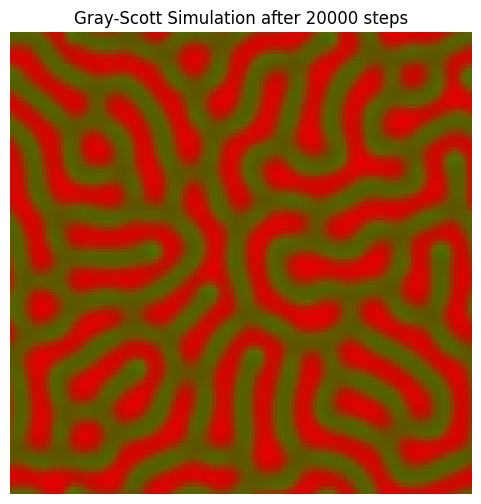

In [ ]:
#@title Example Simulation

# Create an instance of the GrayScottModel
model = GrayScottModel(Du=0.16, Dv=0.08, F=0.060, k=0.062, dt=1.0, size=128, random_influence=0.2)

# Simulate for 20000 steps
model.simulate(num_steps=20000)

# Convert concentrations to RGB image
rgb_image = model.to_rgb()

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(rgb_image)
plt.title('Gray-Scott Simulation after 20000 steps')
plt.axis('off')
plt.show()




In [ ]:
#@title Real Gray Scott

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

class GrayScottModel:
    def __init__(self, Du=0.16, Dv=0.08, F=0.029, k=0.057, dt=1.0, size=64):
        # Parameters (trainable)
        self.Du = tf.Variable(Du, dtype=tf.float32, trainable=True)
        self.Dv = tf.Variable(Dv, dtype=tf.float32, trainable=True)
        self.F = tf.Variable(F, dtype=tf.float32, trainable=True)
        self.k = tf.Variable(k, dtype=tf.float32, trainable=True)
        self.dt = dt
        self.size = size
        # Laplacian kernel (TensorFlow tensor)
        self.laplacian = tf.constant([[0, 1, 0],
                                      [1, -4, 1],
                                      [0, 1, 0]], dtype=tf.float32)

    @staticmethod
    def seed_state(N, random_influence=0.2):
        U = (1 - random_influence) * np.ones((N, N), dtype=np.float32) + \
            random_influence * np.random.random((N, N)).astype(np.float32)
        V = random_influence * np.random.random((N, N)).astype(np.float32)
        N2, r = N // 2, int(N / 10.0)
        U[N2 - r:N2 + r, N2 - r:N2 + r] = 0.50
        V[N2 - r:N2 + r, N2 - r:N2 + r] = 0.25
        U = tf.convert_to_tensor(U, dtype=tf.float32)
        V = tf.convert_to_tensor(V, dtype=tf.float32)
        return U, V

    def to_rgb(self, U, V):
        U_norm = tf.clip_by_value(U, 0.0, 1.0)
        V_norm = tf.clip_by_value(V, 0.0, 1.0)
        zeros = tf.zeros_like(U_norm, dtype=tf.float32)
        rgb = tf.stack([U_norm, V_norm, zeros], axis=-1)
        return rgb  # Float32 tensor in [0, 1]

    def simulate(self, U_init, V_init, num_steps=1000):
        U = U_init
        V = V_init
        U = tf.expand_dims(U, -1)  # Shape: [batch_size, H, W, 1]
        V = tf.expand_dims(V, -1)
        laplacian_kernel = tf.reshape(self.laplacian, [3, 3, 1, 1])

        # Use tf.while_loop for better performance
        def cond(step, U, V):
            return step < num_steps

        def body(step, U, V):
            laplace_U = tf.nn.conv2d(U, laplacian_kernel, strides=1, padding='SAME')
            laplace_V = tf.nn.conv2d(V, laplacian_kernel, strides=1, padding='SAME')
            UVV = U * V * V
            dU = self.Du * laplace_U - UVV + self.F * (1 - U)
            dV = self.Dv * laplace_V + UVV - (self.F + self.k) * V
            U = U + dU * self.dt
            V = V + dV * self.dt
            U = tf.clip_by_value(U, 0.0, 1.0)
            V = tf.clip_by_value(V, 0.0, 1.0)
            return step + 1, U, V

        step = tf.constant(0)
        _, U, V = tf.while_loop(cond, body, [step, U, V])
        U = tf.squeeze(U, -1)  # Shape: [batch_size, H, W]
        V = tf.squeeze(V, -1)
        return U, V

def seed_state_batch(N, batch_size, random_influence=0.2):
    U_batch = []
    V_batch = []
    for _ in range(batch_size):
        U, V = GrayScottModel.seed_state(N, random_influence)
        U_batch.append(U)
        V_batch.append(V)
    U_batch = tf.stack(U_batch)  # Shape: [batch_size, N, N]
    V_batch = tf.stack(V_batch)
    return U_batch, V_batch

def create_augmented_images(target_image):
    # Create augmented images
    augmented_images = [
        target_image,
        tf.image.rot90(target_image, k=1),    # Rotate 90 degrees
        tf.image.rot90(target_image, k=2),    # Rotate 180 degrees
        tf.image.rot90(target_image, k=3),    # Rotate 270 degrees
        tf.image.flip_left_right(target_image),  # Flip horizontally
        tf.image.flip_up_down(target_image),     # Flip vertically
        tf.image.flip_left_right(tf.image.rot90(target_image, k=1)),
        tf.image.flip_left_right(tf.image.rot90(target_image, k=2)),
        tf.image.flip_left_right(tf.image.rot90(target_image, k=3)),
        tf.image.flip_up_down(tf.image.rot90(target_image, k=1)),
        tf.image.flip_up_down(tf.image.rot90(target_image, k=2)),
        tf.image.flip_up_down(tf.image.rot90(target_image, k=3))
    ]
    return augmented_images


In [ ]:
#@title Target Data Generation

# Target Data Generation

# Generate target images at specific time steps
target_model = GrayScottModel(Du=0.16, Dv=0.08, F=0.060, k=0.062, size=64)

# Use fewer time steps
target_steps_list = [0, 2000]  # Only generate for steps 0 and 2000
target_images_dict = {}

# Reduce the number of augmentations
def create_limited_augmented_images(target_image):
    # Create fewer augmented images
    augmented_images = [
        target_image,
        tf.image.rot90(target_image, k=1),    # Rotate 90 degrees
        tf.image.flip_left_right(target_image),  # Flip horizontally
        tf.image.flip_up_down(target_image)     # Flip vertically
    ]
    return augmented_images

# Generate target images for each steps value
for steps in target_steps_list:
    if steps == 0:
        # For steps = 0, use the initial seed state as the target image
        U_target, V_target = seed_state_batch(target_model.size, 1)
    else:
        U_target, V_target = target_model.simulate(
            *seed_state_batch(target_model.size, 1), num_steps=steps)
    target_image = target_model.to_rgb(U_target[0], V_target[0])  # [H, W, 3]
    augmented_images = create_limited_augmented_images(target_image)
    target_images_dict[steps] = augmented_images

# Optionally, visualize the augmented images
# plt.figure(figsize=(12, 8))
# for i, img in enumerate(augmented_images):
#     plt.subplot(3, 4, i+1)
#     plt.imshow(img.numpy())
#     plt.title(f'Augmented Image {i+1}')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

Iteration 500, Loss: 0.03769206628203392
Parameters: Du=0.12658, Dv=0.08832, F=0.04647, k=0.06692


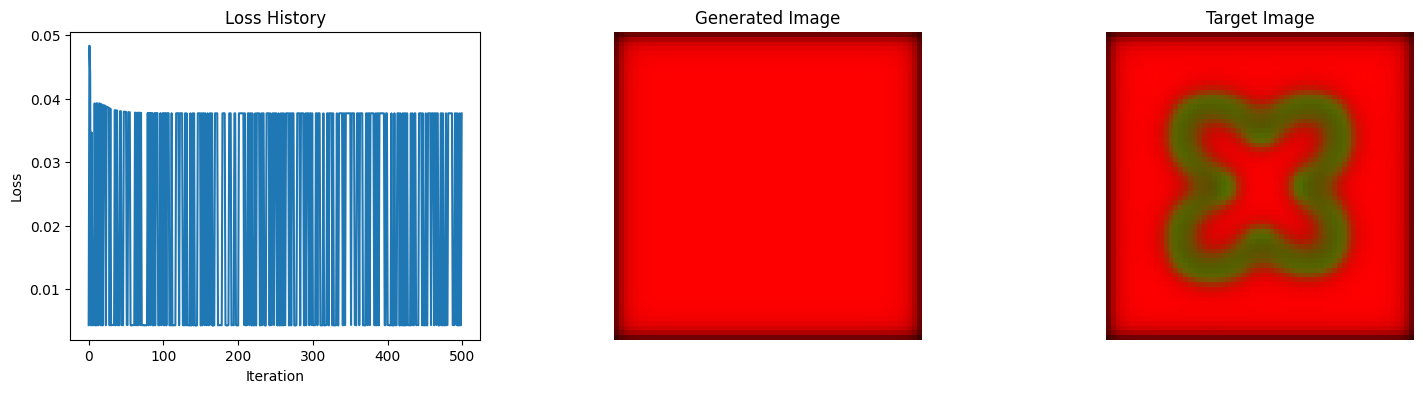

In [ ]:
#@title Training

# Training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust as needed

def compute_loss(generated_images, target_images):
    generated_images = tf.cast(generated_images, tf.float32)
    target_images = tf.cast(target_images, tf.float32)
    loss_value = tf.reduce_mean(tf.square(generated_images - target_images))
    return loss_value

# Parameter constraints: Define minimum and maximum values for the parameters
param_bounds = {
    'Du': (0.0, 1.0),
    'Dv': (0.0, 1.0),
    'F': (0.0, 0.1),
    'k': (0.0, 0.1)
}

# Adjusted train_step function
@tf.function
def train_step(model, U_batch, V_batch, target_images_batch, num_steps):
    with tf.GradientTape() as tape:
        U_gen, V_gen = model.simulate(U_batch, V_batch, num_steps=num_steps)
        generated_images_batch = model.to_rgb(U_gen, V_gen)
        loss_value = compute_loss(generated_images_batch, target_images_batch)
    # Compute gradients and update parameters
    gradients = tape.gradient(loss_value, [model.Du, model.Dv, model.F, model.k])
    # Apply gradient clipping
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    # Update parameters
    optimizer.apply_gradients(zip(gradients, [model.Du, model.Dv, model.F, model.k]))
    # Apply parameter constraints
    model.Du.assign(tf.clip_by_value(model.Du, *param_bounds['Du']))
    model.Dv.assign(tf.clip_by_value(model.Dv, *param_bounds['Dv']))
    model.F.assign(tf.clip_by_value(model.F, *param_bounds['F']))
    model.k.assign(tf.clip_by_value(model.k, *param_bounds['k']))
    return loss_value, generated_images_batch

# Create an instance of the GrayScottModel for training
model = GrayScottModel(size=64)  # Ensure size matches the target image

# Create separate pools for each number of steps
pools = {}
num_steps_pool = [0, 2000]  # Updated to match target_images_dict
for steps in num_steps_pool:
    pool_size = 16  # Adjust as needed
    U_pool, V_pool = seed_state_batch(model.size, pool_size)
    if steps > 0:
        U_pool, V_pool = model.simulate(U_pool, V_pool, num_steps=steps)
    pools[steps] = {'U_pool': U_pool, 'V_pool': V_pool}

# Training loop
num_iterations = 500  # Adjust as needed
batch_size = 4         # Adjust as needed
loss_history = []

for i in range(1, num_iterations + 1):
    # Randomly select the number of steps for this iteration
    steps = random.choice(num_steps_pool)
    pool = pools[steps]
    U_pool = pool['U_pool']
    V_pool = pool['V_pool']
    pool_size = U_pool.shape[0]
    batch_idx = np.random.choice(pool_size, batch_size, replace=False)
    U_batch = tf.gather(U_pool, batch_idx)
    V_batch = tf.gather(V_pool, batch_idx)

    # Periodically inject new seed states
    if i % 32 == 0 and steps == 0:
        new_U, new_V = seed_state_batch(model.size, batch_size)
        U_batch = new_U
        V_batch = new_V

    # Select target images based on the number of steps
    augmented_images = target_images_dict[steps]
    target_images_batch = random.choices(augmented_images, k=batch_size)
    target_images_batch = tf.stack(target_images_batch)

    # Perform a training step
    loss_value, generated_images_batch = train_step(model, U_batch, V_batch, target_images_batch, num_steps=steps)
    loss_history.append(loss_value.numpy())

    # Update the pool with the new states
    if steps > 0:
        U_new, V_new = model.simulate(U_batch, V_batch, num_steps=steps)
        U_pool = tf.tensor_scatter_nd_update(U_pool, tf.expand_dims(batch_idx, axis=1), U_new)
        V_pool = tf.tensor_scatter_nd_update(V_pool, tf.expand_dims(batch_idx, axis=1), V_new)
    else:
        U_pool = tf.tensor_scatter_nd_update(U_pool, tf.expand_dims(batch_idx, axis=1), U_batch)
        V_pool = tf.tensor_scatter_nd_update(V_pool, tf.expand_dims(batch_idx, axis=1), V_batch)
    pool['U_pool'] = U_pool
    pool['V_pool'] = V_pool

    # Logging and plotting
    if i % 500 == 0:
        print(f'Iteration {i}, Loss: {loss_value.numpy()}')
        print(f'Parameters: Du={model.Du.numpy():.5f}, Dv={model.Dv.numpy():.5f}, F={model.F.numpy():.5f}, k={model.k.numpy():.5f}')
        # Plotting
        plt.figure(figsize=(18, 4))
        # Plot loss history
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.title('Loss History')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        # Display generated image (first in batch)
        plt.subplot(1, 3, 2)
        plt.imshow((generated_images_batch[0].numpy()))
        plt.title('Generated Image')
        plt.axis('off')
        # Display target image (first in batch)
        plt.subplot(1, 3, 3)
        plt.imshow((target_images_batch[0].numpy()))
        plt.title('Target Image')
        plt.axis('off')
        plt.show()

In [1]:
#@title VGG16 Style Model
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg16

# Define the StyleModel class
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
CONTENT_LAYER = 'block4_conv2'

class StyleModel:
    def __init__(self):
        # Load the pre-trained VGG16 model
        vgg = vgg16.VGG16(include_top=False, weights='imagenet')
        vgg.trainable = False
        # Extract outputs of the specified layers
        layers = STYLE_LAYERS + [CONTENT_LAYER]
        outputs = [vgg.get_layer(name).output for name in layers]
        self.model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
        self.style_layer_indices = list(range(len(STYLE_LAYERS)))
        self.content_layer_index = len(STYLE_LAYERS)

    def run_model(self, img):
        # Preprocess the images for VGG16
        img = img * 255.0  # Convert from [0, 1] to [0, 255]
        img = img[..., ::-1]  # Convert from RGB to BGR
        mean = np.array([103.939, 116.779, 123.68]).reshape((1, 1, 1, 3))
        img = img - mean  # Subtract mean per channel
        # Get the outputs of the specified layers
        outputs = self.model(img)
        style_outputs = [outputs[i] for i in self.style_layer_indices]
        content_output = outputs[self.content_layer_index]
        return style_outputs, content_output

    def calc_style(self, img):
        style_layers, _ = self.run_model(img)
        # Compute Gram matrices for each style layer
        style_grams = [gram_matrix(a) for a in style_layers]
        return style_grams

def gram_matrix(input_tensor):
    # Compute the Gram matrix for a given input tensor
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

def style_loss(a, b):
    # Compute the style loss between two sets of Gram matrices
    return tf.add_n([tf.reduce_mean(tf.square(x - y)) for x, y in zip(a, b)])

style_model = StyleModel()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#@title Fixed Diffusion Gray Scott Model+VGG16


# Define the GrayScottModel class
class GrayScottModel:
    def __init__(self, Du=0.16, Dv=0.08, F=0.029, k=0.057, dt=1.0, size=128, random_influence=0.2):
        # Fixed diffusion coefficients (not trainable)
        self.Du = Du  # Diffusion rate for U
        self.Dv = Dv  # Diffusion rate for V
        # Trainable parameters
        self.F = tf.Variable(F, dtype=tf.float32, trainable=True)  # Feed rate
        self.k = tf.Variable(k, dtype=tf.float32, trainable=True)  # Kill rate
        self.dt = dt
        self.size = size
        # Laplacian kernel (TensorFlow tensor)
        self.laplacian = tf.constant([[0, 1, 0],
                                      [1, -4, 1],
                                      [0, 1, 0]], dtype=tf.float32)
        # Initialize U and V as TensorFlow tensors
        self.U_init, self.V_init = self.seed_state(size, random_influence)

    @staticmethod
    def seed_state(N, random_influence=0.2):
        U = (1 - random_influence) * np.ones((N, N), dtype=np.float32) + \
            random_influence * np.random.random((N, N)).astype(np.float32)
        V = random_influence * np.random.random((N, N)).astype(np.float32)
        N2, r = N // 2, int(N / 10.0)
        U[N2 - r:N2 + r, N2 - r:N2 + r] = 0.50
        V[N2 - r:N2 + r, N2 - r:N2 + r] = 0.25
        U = tf.convert_to_tensor(U, dtype=tf.float32)
        V = tf.convert_to_tensor(V, dtype=tf.float32)
        return U, V

    def to_rgb(self, U, V):
        U_norm = tf.clip_by_value(U, 0.0, 1.0)
        V_norm = tf.clip_by_value(V, 0.0, 1.0)
        zeros = tf.zeros_like(U_norm, dtype=tf.float32)
        rgb = tf.stack([U_norm, V_norm, zeros], axis=-1)
        return rgb  # Float32 tensor in [0, 1]

    @tf.function
    def simulate(self, num_steps=1000):
        U = self.U_init
        V = self.V_init
        U = tf.expand_dims(tf.expand_dims(U, 0), -1)  # Shape: [1, H, W, 1]
        V = tf.expand_dims(tf.expand_dims(V, 0), -1)
        laplacian_kernel = tf.reshape(self.laplacian, [3, 3, 1, 1])
        for _ in tf.range(num_steps):
            laplace_U = tf.nn.conv2d(U, laplacian_kernel, strides=1, padding='SAME')
            laplace_V = tf.nn.conv2d(V, laplacian_kernel, strides=1, padding='SAME')
            UVV = U * V * V
            dU = self.Du * laplace_U - UVV + self.F * (1 - U)
            dV = self.Dv * laplace_V + UVV - (self.F + self.k) * V
            U = U + dU * self.dt
            V = V + dV * self.dt
            U = tf.clip_by_value(U, 0.0, 1.0)
            V = tf.clip_by_value(V, 0.0, 1.0)
        U = tf.squeeze(U, [0, -1])  # Shape: [H, W]
        V = tf.squeeze(V, [0, -1])
        return U, V

# Generate the target image using known parameters
target_model = GrayScottModel(Du=0.16, Dv=0.08, F=0.060, k=0.062, size=64)
U_target, V_target = target_model.simulate(num_steps=2000)
target_image = target_model.to_rgb(U_target, V_target)  # Float32 tensor in [0, 1]

# Display the target image
plt.figure(figsize=(6, 6))
plt.imshow(target_image.numpy())
plt.title('Target Image')
plt.axis('off')
plt.show()

# Training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust as needed

def compute_loss(generated_image, target_image):
    # Ensure images are of type float32
    generated_image = tf.cast(generated_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    # Add batch dimension
    generated_image = tf.expand_dims(generated_image, axis=0)
    target_image = tf.expand_dims(target_image, axis=0)
    # Compute style features (Gram matrices)
    generated_style_grams = style_model.calc_style(generated_image)
    target_style_grams = style_model.calc_style(target_image)
    # Compute style loss
    loss_value = style_loss(generated_style_grams, target_style_grams)
    return loss_value

# Parameter constraints
param_bounds = {
    'F': (0.0, 0.1),
    'k': (0.0, 0.1)
}

@tf.function
def train_step(model, target_image):
    with tf.GradientTape() as tape:
        # Simulate the model to generate an image
        U_gen, V_gen = model.simulate(num_steps=2000)
        generated_image = model.to_rgb(U_gen, V_gen)
        # Compute the loss using the style loss
        loss_value = compute_loss(generated_image, target_image)
    # Compute gradients with respect to F and k only
    gradients = tape.gradient(loss_value, [model.F, model.k])
    # Apply gradient clipping
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    # Update parameters
    optimizer.apply_gradients(zip(gradients, [model.F, model.k]))
    # Apply parameter constraints
    model.F.assign(tf.clip_by_value(model.F, *param_bounds['F']))
    model.k.assign(tf.clip_by_value(model.k, *param_bounds['k']))
    return loss_value, generated_image

# Training loop
model = GrayScottModel(Du=0.16, Dv=0.08, size=64)  # Fixed Du and Dv

num_iterations = 500
loss_history = []
parameter_history = {
    'F': [],
    'k': []
}

for iteration in range(1, num_iterations + 1):
    loss_value, generated_image = train_step(model, target_image)
    loss_history.append(loss_value.numpy())
    parameter_history['F'].append(model.F.numpy())
    parameter_history['k'].append(model.k.numpy())
    if iteration % 50 == 0:
        print(f'Iteration {iteration}, Loss: {loss_value.numpy()}')
        print(f'Parameters: F={model.F.numpy():.5f}, k={model.k.numpy():.5f}')
        # Plotting
        plt.figure(figsize=(18, 4))
        # Plot loss history
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.title('Loss History')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        # Display generated image
        plt.subplot(1, 3, 2)
        plt.imshow(generated_image.numpy())
        plt.title('Generated Image')
        plt.axis('off')
        # Display target image
        plt.subplot(1, 3, 3)
        plt.imshow(target_image.numpy())
        plt.title('Target Image')
        plt.axis('off')
        plt.show()



In [ ]:
#@title Variable Diffusion Gray Scott Model+VGG16

# Define the GrayScottModel class
class GrayScottModel:
    def __init__(self, Du=0.16, Dv=0.08, F=0.029, k=0.057, dt=1.0, size=128, random_influence=0.2):
        # Trainable diffusion coefficients
        self.Du = tf.Variable(Du, dtype=tf.float32, trainable=True)  # Diffusion rate for U
        self.Dv = tf.Variable(Dv, dtype=tf.float32, trainable=True)  # Diffusion rate for V
        # Trainable parameters
        self.F = tf.Variable(F, dtype=tf.float32, trainable=True)  # Feed rate
        self.k = tf.Variable(k, dtype=tf.float32, trainable=True)  # Kill rate
        self.dt = dt
        self.size = size
        # Laplacian kernel (TensorFlow tensor)
        self.laplacian = tf.constant([[0, 1, 0],
                                      [1, -4, 1],
                                      [0, 1, 0]], dtype=tf.float32)
        # Initialize U and V as TensorFlow tensors
        self.U_init, self.V_init = self.seed_state(size, random_influence)

    @staticmethod
    def seed_state(N, random_influence=0.2):
        U = (1 - random_influence) * np.ones((N, N), dtype=np.float32) + \
            random_influence * np.random.random((N, N)).astype(np.float32)
        V = random_influence * np.random.random((N, N)).astype(np.float32)
        N2, r = N // 2, int(N / 10.0)
        U[N2 - r:N2 + r, N2 - r:N2 + r] = 0.50
        V[N2 - r:N2 + r, N2 - r:N2 + r] = 0.25
        U = tf.convert_to_tensor(U, dtype=tf.float32)
        V = tf.convert_to_tensor(V, dtype=tf.float32)
        return U, V

    def to_rgb(self, U, V):
        U_norm = tf.clip_by_value(U, 0.0, 1.0)
        V_norm = tf.clip_by_value(V, 0.0, 1.0)
        zeros = tf.zeros_like(U_norm, dtype=tf.float32)
        rgb = tf.stack([U_norm, V_norm, zeros], axis=-1)
        return rgb  # Float32 tensor in [0, 1]

    @tf.function
    def simulate(self, num_steps=1000):
        U = self.U_init
        V = self.V_init
        U = tf.expand_dims(tf.expand_dims(U, 0), -1)  # Shape: [1, H, W, 1]
        V = tf.expand_dims(tf.expand_dims(V, 0), -1)
        laplacian_kernel = tf.reshape(self.laplacian, [3, 3, 1, 1])
        for _ in tf.range(num_steps):
            laplace_U = tf.nn.conv2d(U, laplacian_kernel, strides=1, padding='SAME')
            laplace_V = tf.nn.conv2d(V, laplacian_kernel, strides=1, padding='SAME')
            UVV = U * V * V
            dU = self.Du * laplace_U - UVV + self.F * (1 - U)
            dV = self.Dv * laplace_V + UVV - (self.F + self.k) * V
            U = U + dU * self.dt
            V = V + dV * self.dt
            U = tf.clip_by_value(U, 0.0, 1.0)
            V = tf.clip_by_value(V, 0.0, 1.0)
        U = tf.squeeze(U, [0, -1])  # Shape: [H, W]
        V = tf.squeeze(V, [0, -1])
        return U, V

# Generate the target image using known parameters
target_model = GrayScottModel(Du=0.16, Dv=0.08, F=0.060, k=0.062, size=64)
U_target, V_target = target_model.simulate(num_steps=2000)
target_image = target_model.to_rgb(U_target, V_target)  # Float32 tensor in [0, 1]

# Display the target image
plt.figure(figsize=(6, 6))
plt.imshow(target_image.numpy())
plt.title('Target Image')
plt.axis('off')
plt.show()

# Training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust as needed

def compute_loss(generated_image, target_image):
    # Ensure images are of type float32
    generated_image = tf.cast(generated_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    # Add batch dimension
    generated_image = tf.expand_dims(generated_image, axis=0)
    target_image = tf.expand_dims(target_image, axis=0)
    # Compute style features (Gram matrices)
    generated_style_grams = style_model.calc_style(generated_image)
    target_style_grams = style_model.calc_style(target_image)
    # Compute style loss
    loss_value = style_loss(generated_style_grams, target_style_grams)
    return loss_value

# Parameter constraints
param_bounds = {
    'Du': (0.0, 1.0),
    'Dv': (0.0, 1.0),
    'F': (0.0, 0.1),
    'k': (0.0, 0.1)
}

@tf.function
def train_step(model, target_image):
    with tf.GradientTape() as tape:
        # Simulate the model to generate an image
        U_gen, V_gen = model.simulate(num_steps=2000)
        generated_image = model.to_rgb(U_gen, V_gen)
        # Compute the loss using the style loss
        loss_value = compute_loss(generated_image, target_image)
    # Compute gradients with respect to Du, Dv, F, and k
    gradients = tape.gradient(loss_value, [model.Du, model.Dv, model.F, model.k])
    # Apply gradient clipping
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    # Update parameters
    optimizer.apply_gradients(zip(gradients, [model.Du, model.Dv, model.F, model.k]))
    # Apply parameter constraints
    model.Du.assign(tf.clip_by_value(model.Du, *param_bounds['Du']))
    model.Dv.assign(tf.clip_by_value(model.Dv, *param_bounds['Dv']))
    model.F.assign(tf.clip_by_value(model.F, *param_bounds['F']))
    model.k.assign(tf.clip_by_value(model.k, *param_bounds['k']))
    return loss_value, generated_image

# Training loop
model = GrayScottModel(size=64)  # All parameters initialized to default values

num_iterations = 500
loss_history = []
parameter_history = {
    'Du': [],
    'Dv': [],
    'F': [],
    'k': []
}

for iteration in range(1, num_iterations + 1):
    loss_value, generated_image = train_step(model, target_image)
    loss_history.append(loss_value.numpy())
    parameter_history['Du'].append(model.Du.numpy())
    parameter_history['Dv'].append(model.Dv.numpy())
    parameter_history['F'].append(model.F.numpy())
    parameter_history['k'].append(model.k.numpy())
    if iteration % 50 == 0:
        print(f'Iteration {iteration}, Loss: {loss_value.numpy()}')
        print(f'Parameters: Du={model.Du.numpy():.5f}, Dv={model.Dv.numpy():.5f}, '
              f'F={model.F.numpy():.5f}, k={model.k.numpy():.5f}')
        # Plotting
        plt.figure(figsize=(18, 4))
        # Plot loss history
        plt.subplot(1, 4, 1)
        plt.plot(loss_history)
        plt.title('Loss History')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        # Plot parameter values
        plt.subplot(1, 4, 2)
        plt.plot(parameter_history['Du'], label='Du')
        plt.plot(parameter_history['Dv'], label='Dv')
        plt.plot(parameter_history['F'], label='F')
        plt.plot(parameter_history['k'], label='k')
        plt.title('Parameter Values')
        plt.xlabel('Iteration')
        plt.ylabel('Parameter Value')
        plt.legend()
        # Display generated image
        plt.subplot(1, 4, 3)
        plt.imshow(generated_image.numpy())
        plt.title('Generated Image')
        plt.axis('off')
        # Display target image
        plt.subplot(1, 4, 4)
        plt.imshow(target_image.numpy())
        plt.title('Target Image')
        plt.axis('off')
        plt.show()

# After training, print final parameter values
print('Final Parameters:')
print(f'Du = {model.Du.numpy()}')
print(f'Dv = {model.Dv.numpy()}')
print(f'F  = {model.F.numpy()}')
print(f'k  = {model.k.numpy()}')

# Optionally, simulate with the final parameters for more steps
U_final, V_final = model.simulate(num_steps=2000)
generated_final_image = model.to_rgb(U_final, V_final)

# Display the final generated image
plt.figure(figsize=(6, 6))
plt.imshow(generated_final_image.numpy())
plt.title('Final Generated Image')
plt.axis('off')
plt.show()




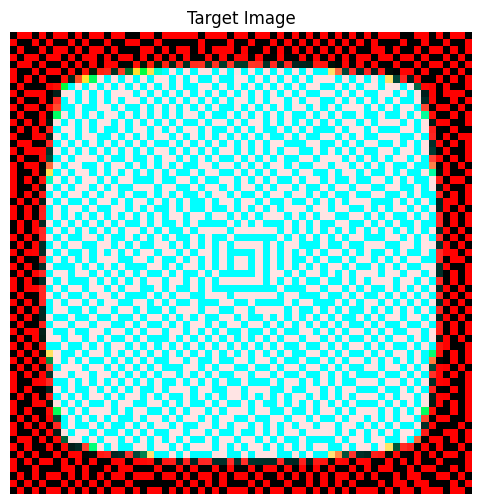

Iteration 50, Loss: 0.37239575386047363
Parameters: Du=0.21701, Dv=0.15030, Dw=0.06566, F=0.06153, kv=0.06008, kw=0.04597


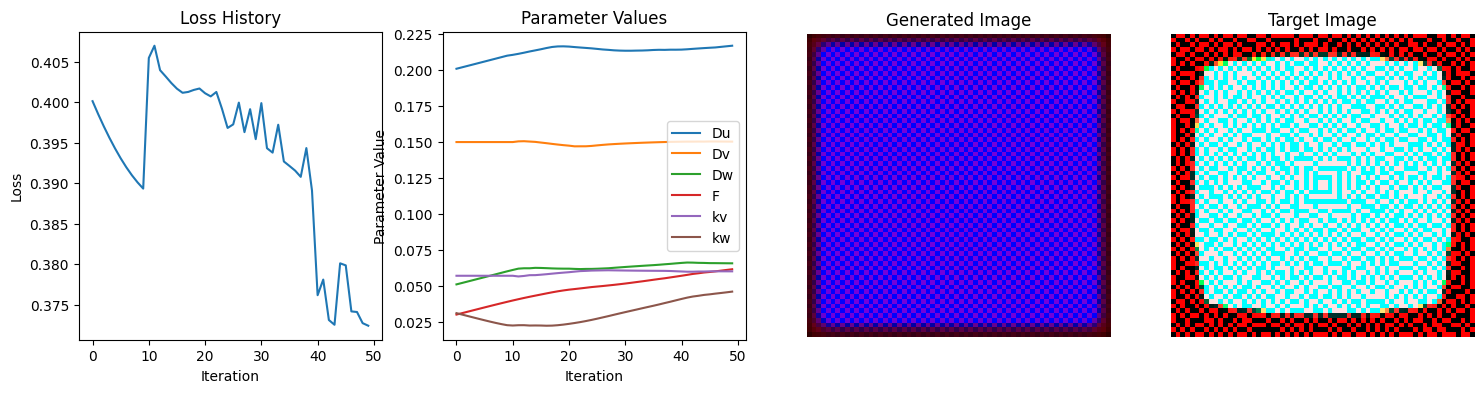

Iteration 100, Loss: 0.5534350275993347
Parameters: Du=0.22369, Dv=0.15001, Dw=0.06581, F=0.05713, kv=0.06002, kw=0.05667


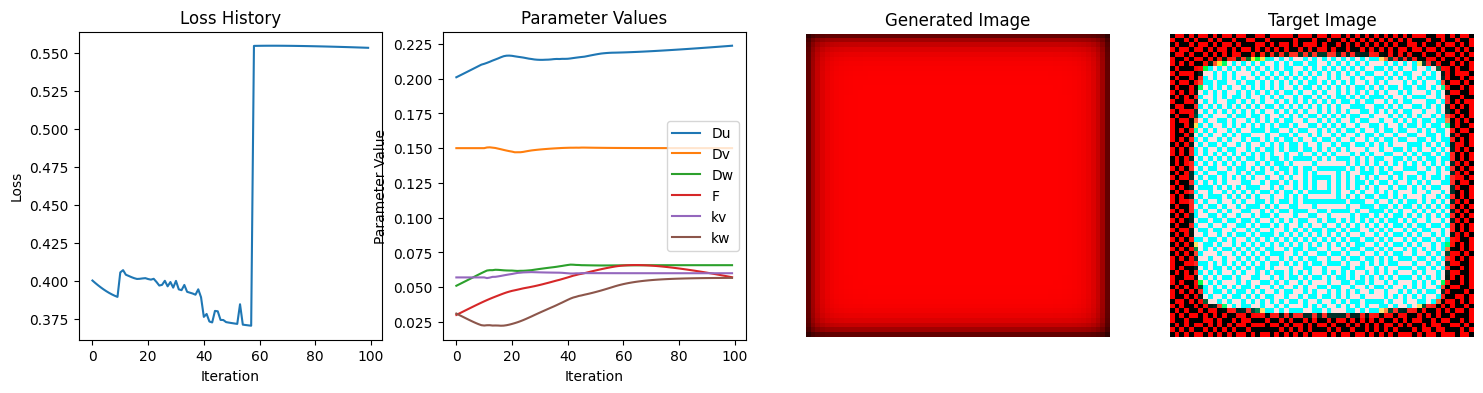

Iteration 150, Loss: 0.4288159906864166
Parameters: Du=0.22239, Dv=0.15025, Dw=0.06625, F=0.03371, kv=0.06032, kw=0.06193


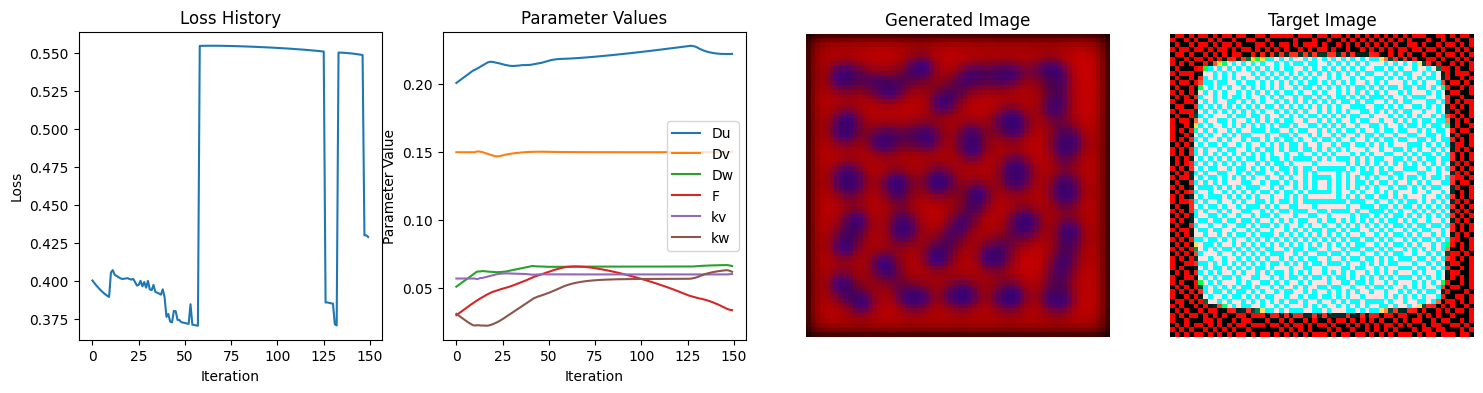

Iteration 200, Loss: 0.3848765194416046
Parameters: Du=0.21946, Dv=0.16509, Dw=0.06153, F=0.05602, kv=0.07937, kw=0.04531


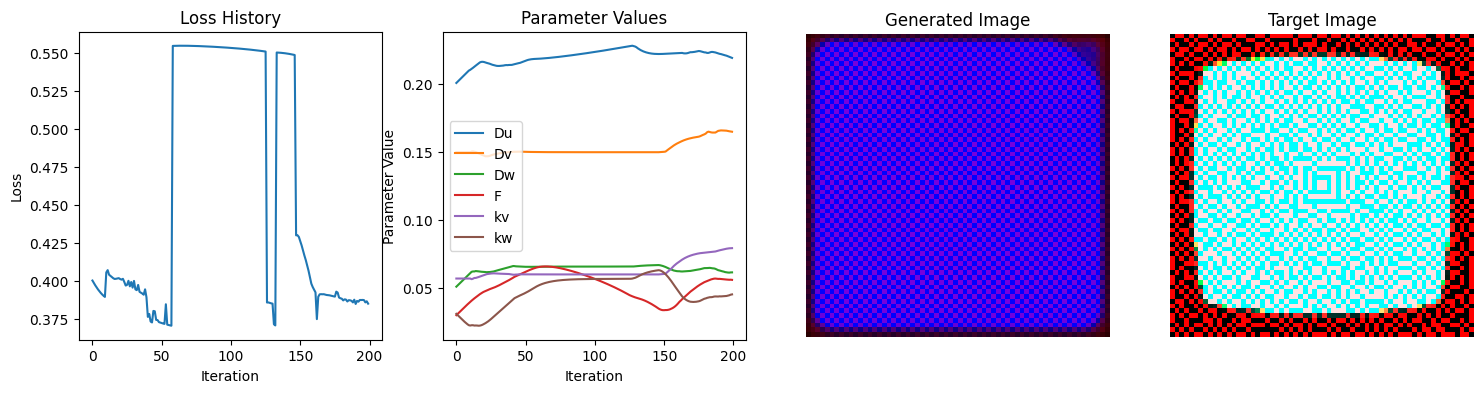

Iteration 250, Loss: 0.3676745593547821
Parameters: Du=0.21621, Dv=0.16538, Dw=0.07602, F=0.07586, kv=0.08279, kw=0.04685


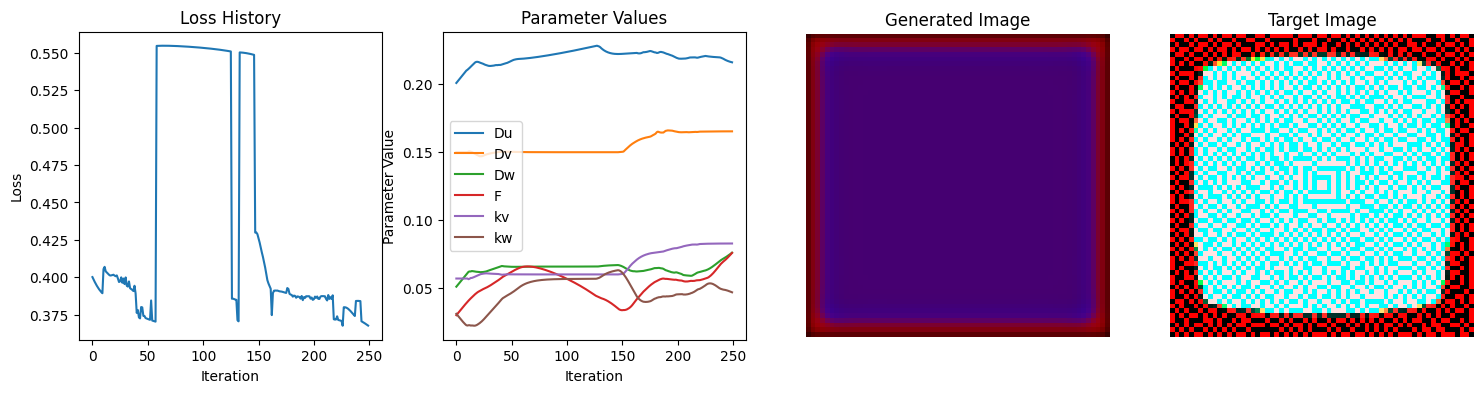

Iteration 300, Loss: 0.557240903377533
Parameters: Du=0.20767, Dv=0.16539, Dw=0.08887, F=0.08441, kv=0.08281, kw=0.04306


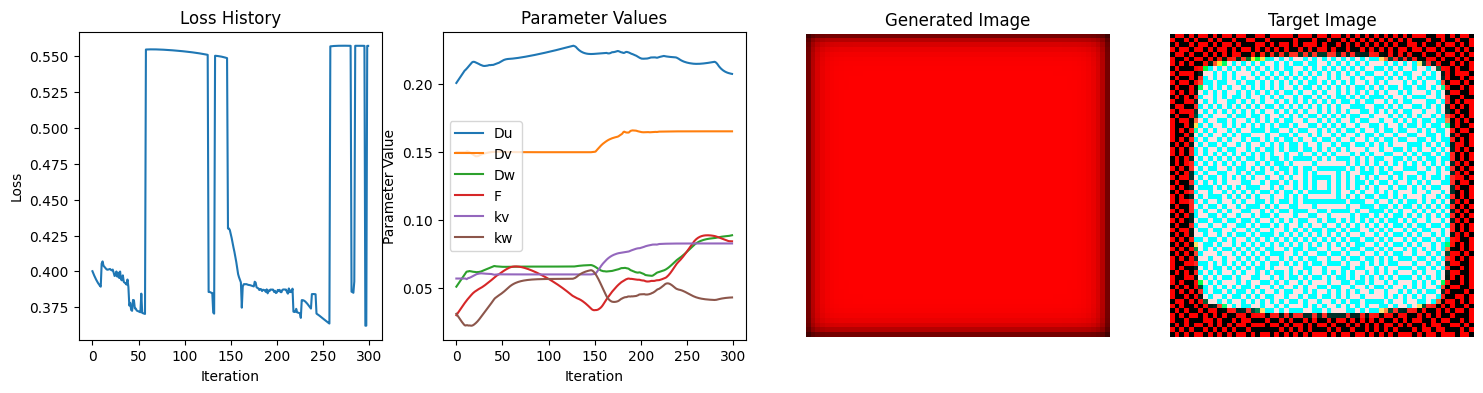

Iteration 350, Loss: 0.5571363568305969
Parameters: Du=0.21169, Dv=0.16539, Dw=0.09557, F=0.08477, kv=0.08282, kw=0.04274


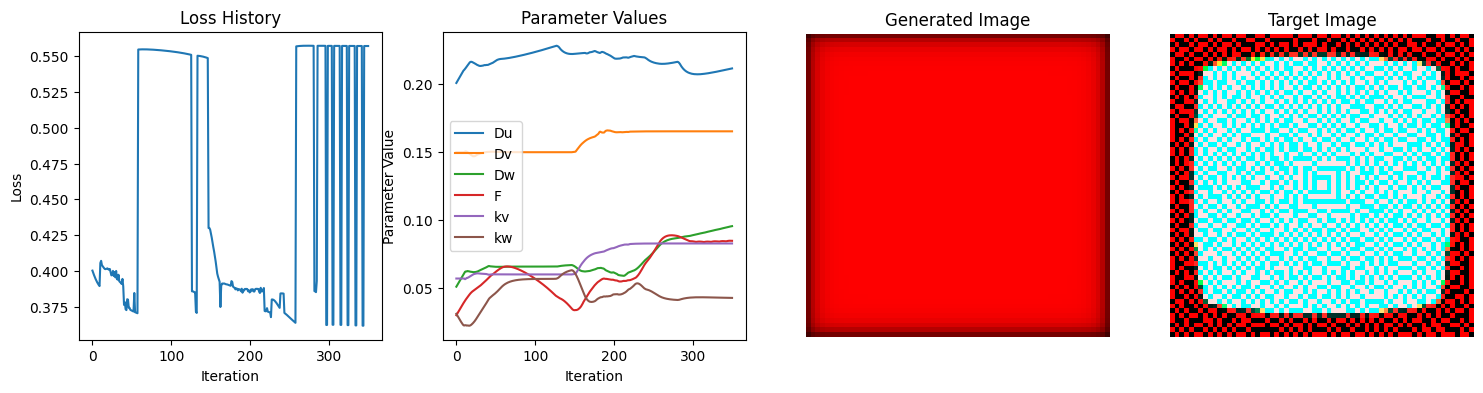

In [ ]:
#@title Variable Diffusion Gray Scott Model (3 params) + VGG16

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the ThreeMorphogenModel class
class ThreeMorphogenModel:
    def __init__(self, Du=0.2, Dv=0.15, Dw=0.05, F=0.029, kv=0.057, kw=0.032, dt=1.0, size=128, random_influence=0.2):
        # Trainable diffusion coefficients
        self.Du = tf.Variable(Du, dtype=tf.float32, trainable=True)  # Diffusion rate for u
        self.Dv = tf.Variable(Dv, dtype=tf.float32, trainable=True)  # Diffusion rate for v
        self.Dw = tf.Variable(Dw, dtype=tf.float32, trainable=True)  # Diffusion rate for w
        # Trainable parameters
        self.F = tf.Variable(F, dtype=tf.float32, trainable=True)    # Feed rate
        self.kv = tf.Variable(kv, dtype=tf.float32, trainable=True)  # Kill rate for v
        self.kw = tf.Variable(kw, dtype=tf.float32, trainable=True)  # Kill rate for w
        self.dt = dt
        self.size = size
        # Laplacian kernel (TensorFlow tensor)
        self.laplacian = tf.constant([[0, 1, 0],
                                      [1, -4, 1],
                                      [0, 1, 0]], dtype=tf.float32)
        # Initialize u, v, w as TensorFlow tensors
        self.U_init, self.V_init, self.W_init = self.seed_state(size, random_influence)

    @staticmethod
    def seed_state(N, random_influence=0.2):
        U = (1 - random_influence) * np.ones((N, N), dtype=np.float32) + \
            random_influence * np.random.random((N, N)).astype(np.float32)
        V = random_influence * np.random.random((N, N)).astype(np.float32)
        W = random_influence * np.random.random((N, N)).astype(np.float32)
        N2, r = N // 2, int(N / 10.0)
        U[N2 - r:N2 + r, N2 - r:N2 + r] = 0.50
        V[N2 - r:N2 + r, N2 - r:N2 + r] = 0.25
        W[N2 - r:N2 + r, N2 - r:N2 + r] = 0.25
        U = tf.convert_to_tensor(U, dtype=tf.float32)
        V = tf.convert_to_tensor(V, dtype=tf.float32)
        W = tf.convert_to_tensor(W, dtype=tf.float32)
        return U, V, W

    def to_rgb(self, U, V, W):
        U_norm = tf.clip_by_value(U, 0.0, 1.0)
        V_norm = tf.clip_by_value(V, 0.0, 1.0)
        W_norm = tf.clip_by_value(W, 0.0, 1.0)
        rgb = tf.stack([U_norm, V_norm, W_norm], axis=-1)
        return rgb  # Float32 tensor in [0, 1]

    @tf.function
    def simulate(self, num_steps=1000):
        U = self.U_init
        V = self.V_init
        W = self.W_init
        U = tf.expand_dims(tf.expand_dims(U, 0), -1)  # Shape: [1, H, W, 1]
        V = tf.expand_dims(tf.expand_dims(V, 0), -1)
        W = tf.expand_dims(tf.expand_dims(W, 0), -1)
        laplacian_kernel = tf.reshape(self.laplacian, [3, 3, 1, 1])
        for _ in tf.range(num_steps):
            laplace_U = tf.nn.conv2d(U, laplacian_kernel, strides=1, padding='SAME')
            laplace_V = tf.nn.conv2d(V, laplacian_kernel, strides=1, padding='SAME')
            laplace_W = tf.nn.conv2d(W, laplacian_kernel, strides=1, padding='SAME')
            UVV = U * V * V
            UWW = U * W * W
            dU = self.Du * laplace_U - UVV - UWW + self.F * (1 - U)
            dV = self.Dv * laplace_V + UVV - (self.F + self.kv) * V
            dW = self.Dw * laplace_W + UWW - (self.F + self.kw) * W
            U = U + dU * self.dt
            V = V + dV * self.dt
            W = W + dW * self.dt
            U = tf.clip_by_value(U, 0.0, 1.0)
            V = tf.clip_by_value(V, 0.0, 1.0)
            W = tf.clip_by_value(W, 0.0, 1.0)
        U = tf.squeeze(U, [0, -1])  # Shape: [H, W]
        V = tf.squeeze(V, [0, -1])
        W = tf.squeeze(W, [0, -1])
        return U, V, W

# Generate the target image using known parameters
target_model = ThreeMorphogenModel(Du=1.0, Dv=0.01, Dw=0.01, F=0.04, kv=0.06, kw=0.06, size=64)
U_target, V_target, W_target = target_model.simulate(num_steps=2000)
target_image = target_model.to_rgb(U_target, V_target, W_target)  # Float32 tensor in [0, 1]

# Display the target image
plt.figure(figsize=(6, 6))
plt.imshow(target_image.numpy())
plt.title('Target Image')
plt.axis('off')
plt.show()

# Training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust as needed

def compute_loss(generated_image, target_image):
    # Ensure images are of type float32
    generated_image = tf.cast(generated_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    # Compute Mean Squared Error
    loss_value = tf.reduce_mean(tf.square(generated_image - target_image))
    return loss_value

# Parameter constraints
param_bounds = {
    'Du': (0.0, 1.0),
    'Dv': (0.0, 1.0),
    'Dw': (0.0, 1.0),
    'F': (0.0, 0.1),
    'kv': (0.0, 0.1),
    'kw': (0.0, 0.1)
}

@tf.function
def train_step(model, target_image):
    with tf.GradientTape() as tape:
        # Simulate the model to generate an image
        U_gen, V_gen, W_gen = model.simulate(num_steps=2000)
        generated_image = model.to_rgb(U_gen, V_gen, W_gen)
        # Compute the loss using Mean Squared Error
        loss_value = compute_loss(generated_image, target_image)
    # Compute gradients with respect to Du, Dv, Dw, F, kv, kw
    gradients = tape.gradient(loss_value, [model.Du, model.Dv, model.Dw, model.F, model.kv, model.kw])
    # Apply gradient clipping
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    # Update parameters
    optimizer.apply_gradients(zip(gradients, [model.Du, model.Dv, model.Dw, model.F, model.kv, model.kw]))
    # Apply parameter constraints
    model.Du.assign(tf.clip_by_value(model.Du, *param_bounds['Du']))
    model.Dv.assign(tf.clip_by_value(model.Dv, *param_bounds['Dv']))
    model.Dw.assign(tf.clip_by_value(model.Dw, *param_bounds['Dw']))
    model.F.assign(tf.clip_by_value(model.F, *param_bounds['F']))
    model.kv.assign(tf.clip_by_value(model.kv, *param_bounds['kv']))
    model.kw.assign(tf.clip_by_value(model.kw, *param_bounds['kw']))
    return loss_value, generated_image

# Training loop
model = ThreeMorphogenModel(size=64)  # All parameters initialized to default values

num_iterations = 500
loss_history = []
parameter_history = {
    'Du': [],
    'Dv': [],
    'Dw': [],
    'F': [],
    'kv': [],
    'kw': []
}

for iteration in range(1, num_iterations + 1):
    loss_value, generated_image = train_step(model, target_image)
    loss_history.append(loss_value.numpy())
    parameter_history['Du'].append(model.Du.numpy())
    parameter_history['Dv'].append(model.Dv.numpy())
    parameter_history['Dw'].append(model.Dw.numpy())
    parameter_history['F'].append(model.F.numpy())
    parameter_history['kv'].append(model.kv.numpy())
    parameter_history['kw'].append(model.kw.numpy())
    if iteration % 50 == 0:
        print(f'Iteration {iteration}, Loss: {loss_value.numpy()}')
        print(f'Parameters: Du={model.Du.numpy():.5f}, Dv={model.Dv.numpy():.5f}, '
              f'Dw={model.Dw.numpy():.5f}, F={model.F.numpy():.5f}, kv={model.kv.numpy():.5f}, kw={model.kw.numpy():.5f}')
        # Plotting
        plt.figure(figsize=(18, 4))
        # Plot loss history
        plt.subplot(1, 4, 1)
        plt.plot(loss_history)
        plt.title('Loss History')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        # Plot parameter values
        plt.subplot(1, 4, 2)
        plt.plot(parameter_history['Du'], label='Du')
        plt.plot(parameter_history['Dv'], label='Dv')
        plt.plot(parameter_history['Dw'], label='Dw')
        plt.plot(parameter_history['F'], label='F')
        plt.plot(parameter_history['kv'], label='kv')
        plt.plot(parameter_history['kw'], label='kw')
        plt.title('Parameter Values')
        plt.xlabel('Iteration')
        plt.ylabel('Parameter Value')
        plt.legend()
        # Display generated image
        plt.subplot(1, 4, 3)
        plt.imshow(generated_image.numpy())
        plt.title('Generated Image')
        plt.axis('off')
        # Display target image
        plt.subplot(1, 4, 4)
        plt.imshow(target_image.numpy())
        plt.title('Target Image')
        plt.axis('off')
        plt.show()

# After training, print final parameter values
print('Final Parameters:')
print(f'Du = {model.Du.numpy()}')
print(f'Dv = {model.Dv.numpy()}')
print(f'Dw = {model.Dw.numpy()}')
print(f'F  = {model.F.numpy()}')
print(f'kv = {model.kv.numpy()}')
print(f'kw = {model.kw.numpy()}')

# Optionally, simulate with the final parameters for more steps
U_final, V_final, W_final = model.simulate(num_steps=2000)
generated_final_image = model.to_rgb(U_final, V_final, W_final)

# Display the final generated image
plt.figure(figsize=(6, 6))
plt.imshow(generated_final_image.numpy())
plt.title('Final Generated Image')
plt.axis('off')
plt.show()


In [ ]:
!pip install pysindy

In [ ]:
#@title Helper Functions
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import io

def download_image(url, output_path='target_image.png'):
    """
    Downloads an image from a specified URL and saves it locally.

    Args:
        url (str): URL of the image to download.
        output_path (str): Local path to save the downloaded image.

    Returns:
        None
    """
    try:
        response = urllib.request.urlopen(url)
        image_data = response.read()
        with open(output_path, 'wb') as f:
            f.write(image_data)
        print(f"Image downloaded successfully and saved to {output_path}")
    except Exception as e:
        print(f"Error downloading the image: {e}")

def load_target_image(image_path, target_size=(64, 64)):
    """
    Loads and preprocesses the target image.

    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired size as (width, height).

    Returns:
        tf.Tensor: Preprocessed image tensor with shape [H, W, 3] and values in [0, 1].
    """
    try:
        # Open the image using Pillow
        img = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format

        # Resize the image to match the model's input size
        img = img.resize(target_size, Image.BICUBIC)

        # Convert the image to a NumPy array and normalize to [0, 1]
        img_array = np.array(img).astype(np.float32) / 255.0

        # Convert to TensorFlow tensor
        img_tensor = tf.convert_to_tensor(img_array)

        return img_tensor
    except Exception as e:
        print(f"Error loading the image: {e}")

def verify_image(image_tensor):
    """
    Verifies the loaded image by displaying it and printing its properties.

    Args:
        image_tensor (tf.Tensor): Image tensor to verify.

    Returns:
        None
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image_tensor.numpy())
    plt.title('Loaded Target Image')
    plt.axis('off')
    plt.show()

    print(f"Image shape: {image_tensor.shape}")
    print(f"Pixel value range: [{tf.reduce_min(image_tensor).numpy():.4f}, {tf.reduce_max(image_tensor).numpy():.4f}]")


In [ ]:
#@title SINDy: Generating Polynomial Terms for Three Chemicals

import numpy as np
import pysindy as ps

# Define the names of the morphogens (chemicals)
feature_names = ['c1', 'c2', 'c3']

# Number of variables
num_var = len(feature_names)

# Specify the maximum polynomial order
poly_order = 3  # Adjust as needed

# Create the polynomial library
feature_library = ps.PolynomialLibrary(degree=poly_order)

# Initialize the optimizer (parameters are irrelevant for generating terms)
sparse_regression_optimizer = ps.STLSQ(threshold=0.01, alpha=0.01)

# Initialize the SINDy model
model = ps.SINDy(
    feature_names=feature_names,
    feature_library=feature_library,
    optimizer=sparse_regression_optimizer
)

# Generate fake data - this does not impact the library
x_train = np.ones((100, num_var))
t_train = np.linspace(0, 1, 100)

# Fit the model to generate the feature names
model.fit(x_train, t=t_train)

# Retrieve the list of feature names (polynomial terms)
sindy_feature_names = model.get_feature_names()
print("Generated Polynomial Terms:")
print(sindy_feature_names)


Generated Polynomial Terms:
['1', 'c1', 'c2', 'c3', 'c1^2', 'c1 c2', 'c1 c3', 'c2^2', 'c2 c3', 'c3^2', 'c1^3', 'c1^2 c2', 'c1^2 c3', 'c1 c2^2', 'c1 c2 c3', 'c1 c3^2', 'c2^3', 'c2^2 c3', 'c2 c3^2', 'c3^3']


/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


In [ ]:
#@title Modified ThreeMorphogenModel with Jacobian and SINDy Terms

import numpy as np
import tensorflow as tf

class ThreeMorphogenModel:
    def __init__(self, dt=0.001, size=64, random_influence=0.05):
        self.dt = dt
        self.size = size
        # Laplacian kernel (TensorFlow tensor)
        self.laplacian = tf.constant([[0, 1, 0],
                                      [1, -4, 1],
                                      [0, 1, 0]], dtype=tf.float32)
        # Initialize c1, c2, and c3 as TensorFlow tensors
        self.c1_init, self.c2_init, self.c3_init = self.seed_state(size, random_influence)
        # Generate the list of SINDy terms
        self.sindy_terms = sindy_feature_names  # Includes '1'

        # Steady-state concentrations
        self.c1_0 = tf.constant(1.0, dtype=tf.float32)
        self.c2_0 = tf.constant(1.0, dtype=tf.float32)
        self.c3_0 = tf.constant(1.0, dtype=tf.float32)

        # Jacobian coefficients (trainable or fixed)
        self.a11 = tf.Variable(-2.0, dtype=tf.float32, trainable=True)
        self.a12 = tf.Variable(3.0, dtype=tf.float32, trainable=True)
        self.a13 = tf.Variable(2.0, dtype=tf.float32, trainable=True)
        self.a21 = tf.Variable(-2.0, dtype=tf.float32, trainable=True)
        self.a22 = tf.Variable(2.0/3.0, dtype=tf.float32, trainable=True)
        self.a23 = tf.Variable(0.0, dtype=tf.float32, trainable=True)
        self.a31 = tf.Variable(3.0, dtype=tf.float32, trainable=True)
        self.a32 = tf.Variable(-4.0, dtype=tf.float32, trainable=True)
        self.a33 = tf.Variable(0.0, dtype=tf.float32, trainable=True)

        # Coefficients for non-linear terms (excluding linear terms and constant term)
        self.non_linear_terms = self.sindy_terms[4:]  # Terms from index 4 onwards
        self.coefficients_F_nl = [tf.Variable(0.0, dtype=tf.float32, trainable=True) for _ in self.non_linear_terms]
        self.coefficients_G_nl = [tf.Variable(0.0, dtype=tf.float32, trainable=True) for _ in self.non_linear_terms]
        self.coefficients_H_nl = [tf.Variable(0.0, dtype=tf.float32, trainable=True) for _ in self.non_linear_terms]

        # Diffusion coefficients (trainable)
        self.D1 = tf.Variable(0.16, dtype=tf.float32, trainable=True)
        self.D2 = tf.Variable(0.08, dtype=tf.float32, trainable=True)
        self.D3 = tf.Variable(0.0, dtype=tf.float32, trainable=True)

    @staticmethod
    def seed_state(N, random_influence=0.05):
        # Initialize near equilibrium with small perturbations
        c1 = np.ones((N, N), dtype=np.float32) + random_influence * np.random.randn(N, N)
        c2 = np.ones((N, N), dtype=np.float32) + random_influence * np.random.randn(N, N)
        c3 = np.ones((N, N), dtype=np.float32) + random_influence * np.random.randn(N, N)
        # Add central perturbation
        N2, r = N // 2, int(N / 10.0)
        c1[N2 - r:N2 + r, N2 - r:N2 + r] += 0.05 * np.random.randn(2*r, 2*r)
        c2[N2 - r:N2 + r, N2 - r:N2 + r] += 0.05 * np.random.randn(2*r, 2*r)
        c3[N2 - r:N2 + r, N2 - r:N2 + r] += 0.05 * np.random.randn(2*r, 2*r)
        c1 = tf.convert_to_tensor(c1, dtype=tf.float32)
        c2 = tf.convert_to_tensor(c2, dtype=tf.float32)
        c3 = tf.convert_to_tensor(c3, dtype=tf.float32)
        return c1, c2, c3

    def to_rgb(self, c1, c2, c3):
        # Normalize for visualization
        c1_norm = tf.clip_by_value((c1 - tf.reduce_min(c1)) / (tf.reduce_max(c1) - tf.reduce_min(c1) + 1e-8), 0.0, 1.0)
        c2_norm = tf.clip_by_value((c2 - tf.reduce_min(c2)) / (tf.reduce_max(c2) - tf.reduce_min(c2) + 1e-8), 0.0, 1.0)
        c3_norm = tf.clip_by_value((c3 - tf.reduce_min(c3)) / (tf.reduce_max(c3) - tf.reduce_min(c3) + 1e-8), 0.0, 1.0)
        rgb = tf.stack([c1_norm, c2_norm, c3_norm], axis=-1)
        return rgb  # Float32 tensor in [0, 1]

    @tf.function
    def simulate(self, num_steps=1000):
        c1 = self.c1_init
        c2 = self.c2_init
        c3 = self.c3_init
        # Expand dimensions for convolution
        c1 = tf.expand_dims(tf.expand_dims(c1, 0), -1)  # Shape: [1, H, W, 1]
        c2 = tf.expand_dims(tf.expand_dims(c2, 0), -1)
        c3 = tf.expand_dims(tf.expand_dims(c3, 0), -1)
        laplacian_kernel = tf.reshape(self.laplacian, [3, 3, 1, 1])

        for _ in tf.range(num_steps):
            # Compute Laplacians
            laplace_c1 = tf.nn.conv2d(c1, laplacian_kernel, strides=1, padding='SAME')
            laplace_c2 = tf.nn.conv2d(c2, laplacian_kernel, strides=1, padding='SAME')
            laplace_c3 = tf.nn.conv2d(c3, laplacian_kernel, strides=1, padding='SAME')

            # Reaction terms
            FU = self.compute_reaction_F(c1, c2, c3)
            FV = self.compute_reaction_G(c1, c2, c3)
            FW = self.compute_reaction_H(c1, c2, c3)

            # Update concentrations
            dc1 = self.D1 * laplace_c1 + FU
            dc2 = self.D2 * laplace_c2 + FV
            dc3 = self.D3 * laplace_c3 + FW

            c1 = c1 + dc1 * self.dt
            c2 = c2 + dc2 * self.dt
            c3 = c3 + dc3 * self.dt

            # Ensure non-negative concentrations
            c1 = tf.maximum(c1, 0.0)
            c2 = tf.maximum(c2, 0.0)
            c3 = tf.maximum(c3, 0.0)

        c1 = tf.squeeze(c1, [0, -1])  # Shape: [H, W]
        c2 = tf.squeeze(c2, [0, -1])
        c3 = tf.squeeze(c3, [0, -1])
        return c1, c2, c3

    def compute_reaction_F(self, c1, c2, c3):
        # Linear terms using Jacobian coefficients
        linear_term = (
            self.a11 * (c1 - self.c1_0) +
            self.a12 * (c2 - self.c2_0) +
            self.a13 * (c3 - self.c3_0)
        )
        # Non-linear terms
        non_linear_term = self.compute_non_linear_terms(c1, c2, c3, self.coefficients_F_nl)
        return linear_term + non_linear_term

    def compute_reaction_G(self, c1, c2, c3):
        linear_term = (
            self.a21 * (c1 - self.c1_0) +
            self.a22 * (c2 - self.c2_0) +
            self.a23 * (c3 - self.c3_0)
        )
        non_linear_term = self.compute_non_linear_terms(c1, c2, c3, self.coefficients_G_nl)
        return linear_term + non_linear_term

    def compute_reaction_H(self, c1, c2, c3):
        linear_term = (
            self.a31 * (c1 - self.c1_0) +
            self.a32 * (c2 - self.c2_0) +
            self.a33 * (c3 - self.c3_0)
        )
        non_linear_term = self.compute_non_linear_terms(c1, c2, c3, self.coefficients_H_nl)
        return linear_term + non_linear_term

    def compute_non_linear_terms(self, c1, c2, c3, coefficients):
        # Prepare the variables
        variables = {'c1': c1, 'c2': c2, 'c3': c3}
        # Compute each non-linear term in the SINDy library (excluding linear terms)
        terms = []
        for term in self.non_linear_terms:
            # Parse the term and compute its value
            term_value = self.evaluate_term(term, variables)
            terms.append(term_value)
        # Combine terms with coefficients
        non_linear_reaction = tf.add_n([coeff * term for coeff, term in zip(coefficients, terms)])
        return non_linear_reaction

    def evaluate_term(self, term, variables):
        # Split the term into factors
        factors = term.split(' ')
        result = tf.ones_like(list(variables.values())[0])
        for factor in factors:
            # Handle powers
            if '^' in factor:
                var_name, power = factor.split('^')
                var = variables[var_name]
                power = int(power)
                result *= tf.pow(var, power)
            else:
                var = variables[factor]
                result *= var
        return result


In [ ]:
#@title Training the Model with Combined Jacobian and SINDy Terms

import tensorflow as tf
import matplotlib.pyplot as plt

# URL of the target image on GitHub
image_url = 'https://raw.githubusercontent.com/Keshav-Sundar-4/Gray-Scott/main/Gray_Scott_Target3.png'

# Download the image
download_image(image_url, 'target_image.png')

# Load and preprocess the target image
target_image = load_target_image('target_image.png', target_size=(64, 64))

# Initialize the model
model = ThreeMorphogenModel(size=64)

# Assume style_model and style_loss are already defined as per your setup

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Define the compute_loss function
def compute_loss(generated_image, target_image):
    # Ensure images are of type float32
    generated_image = tf.cast(generated_image, tf.float32)
    target_image = tf.cast(target_image, tf.float32)
    # Add batch dimension
    generated_image = tf.expand_dims(generated_image, axis=0)
    target_image = tf.expand_dims(target_image, axis=0)
    # Compute style features (Gram matrices)
    generated_style_grams = style_model.calc_style(generated_image)
    target_style_grams = style_model.calc_style(target_image)
    # Compute style loss
    loss_value = style_loss(generated_style_grams, target_style_grams)
    return loss_value

# Collect all trainable variables
trainable_variables = (
    [model.D1, model.D2, model.D3] +
    [model.a11, model.a12, model.a13, model.a21, model.a22, model.a23, model.a31, model.a32, model.a33] +
    model.coefficients_F_nl +
    model.coefficients_G_nl +
    model.coefficients_H_nl
)

# Define the train_step function
@tf.function
def train_step(model, target_image):
    with tf.GradientTape() as tape:
        # Simulate the model to generate an image
        c1_gen, c2_gen, c3_gen = model.simulate(num_steps=2000)
        generated_image = model.to_rgb(c1_gen, c2_gen, c3_gen)
        # Compute the loss using the style loss
        loss_value = compute_loss(generated_image, target_image)
    # Compute gradients with respect to all trainable variables
    gradients = tape.gradient(loss_value, trainable_variables)
    # Apply gradient clipping
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    # Update parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    # Apply parameter constraints if necessary
    return loss_value, generated_image

# Training loop
num_iterations = 500
loss_history = []

for iteration in range(1, num_iterations + 1):
    loss_value, generated_image = train_step(model, target_image)
    loss_history.append(loss_value.numpy())
    if iteration % 50 == 0:
        print(f'Iteration {iteration}, Loss: {loss_value.numpy()}')
        # Plotting
        plt.figure(figsize=(12, 4))
        # Plot loss history
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.title('Loss History')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        # Display generated image
        plt.subplot(1, 3, 2)
        plt.imshow(generated_image.numpy())
        plt.title('Generated Image')
        plt.axis('off')
        # Display target image
        plt.subplot(1, 3, 3)
        plt.imshow(target_image.numpy())
        plt.title('Target Image')
        plt.axis('off')
        plt.show()

# After training, print final parameter values
print('Final Diffusion Coefficients:')
print(f'D1 = {model.D1.numpy()}')
print(f'D2 = {model.D2.numpy()}')
print(f'D3 = {model.D3.numpy()}')

print('Final Jacobian Coefficients:')
print(f'a11 = {model.a11.numpy()}')
print(f'a12 = {model.a12.numpy()}')
print(f'a13 = {model.a13.numpy()}')
print(f'a21 = {model.a21.numpy()}')
print(f'a22 = {model.a22.numpy()}')
print(f'a23 = {model.a23.numpy()}')
print(f'a31 = {model.a31.numpy()}')
print(f'a32 = {model.a32.numpy()}')
print(f'a33 = {model.a33.numpy()}')

# Optionally, simulate with the final parameters for more steps
c1_final, c2_final, c3_final = model.simulate(num_steps=2000)
generated_final_image = model.to_rgb(c1_final, c2_final, c3_final)

# Display the final generated image
plt.figure(figsize=(6, 6))
plt.imshow(generated_final_image.numpy())
plt.title('Final Generated Image')
plt.axis('off')
plt.show()
